<a href="https://colab.research.google.com/github/khizer12khoker/Task1/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


✅ Train Accuracy: 82.56%
✅ Test  Accuracy: 88.29%
✅ Final Weights: [np.float64(0.5934275764452847), np.float64(-0.5778453042997485), np.float64(-1.346511444257369), np.float64(1.8087680577564627), np.float64(-0.5157040480895064), np.float64(-0.3118736572252539), np.float64(0.0936261678715198), np.float64(0.6271375760032595), np.float64(1.43201964627963), np.float64(-1.0588836095790133), np.float64(-1.2786829441308485), np.float64(1.4667462835941296), np.float64(-1.8139733665969588), np.float64(-1.0673868300489022)]

✅ Train Accuracy with Regularization: 78.78%
✅ Test  Accuracy with Regularization: 85.85%
✅ Final Weights with Regularization: [np.float64(0.10227345517448948), np.float64(-0.10799977532061261), np.float64(-0.35805136894391665), np.float64(0.4719484183753121), np.float64(-0.05992870228889858), np.float64(-0.03136331744570464), np.float64(-0.0016166045319351958), np.float64(0.13756271450208543), np.float64(0.30221735495256613), np.float64(-0.4857092005423527), np.float64(-0

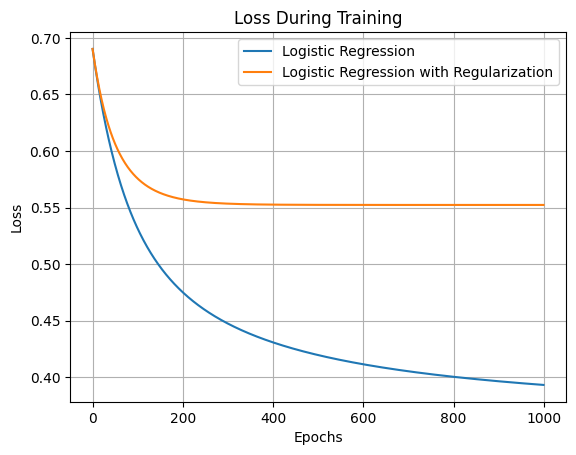

First 5 rows of the DataFrame:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

Descriptive Statistics:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000



Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Histograms of Numerical Features:


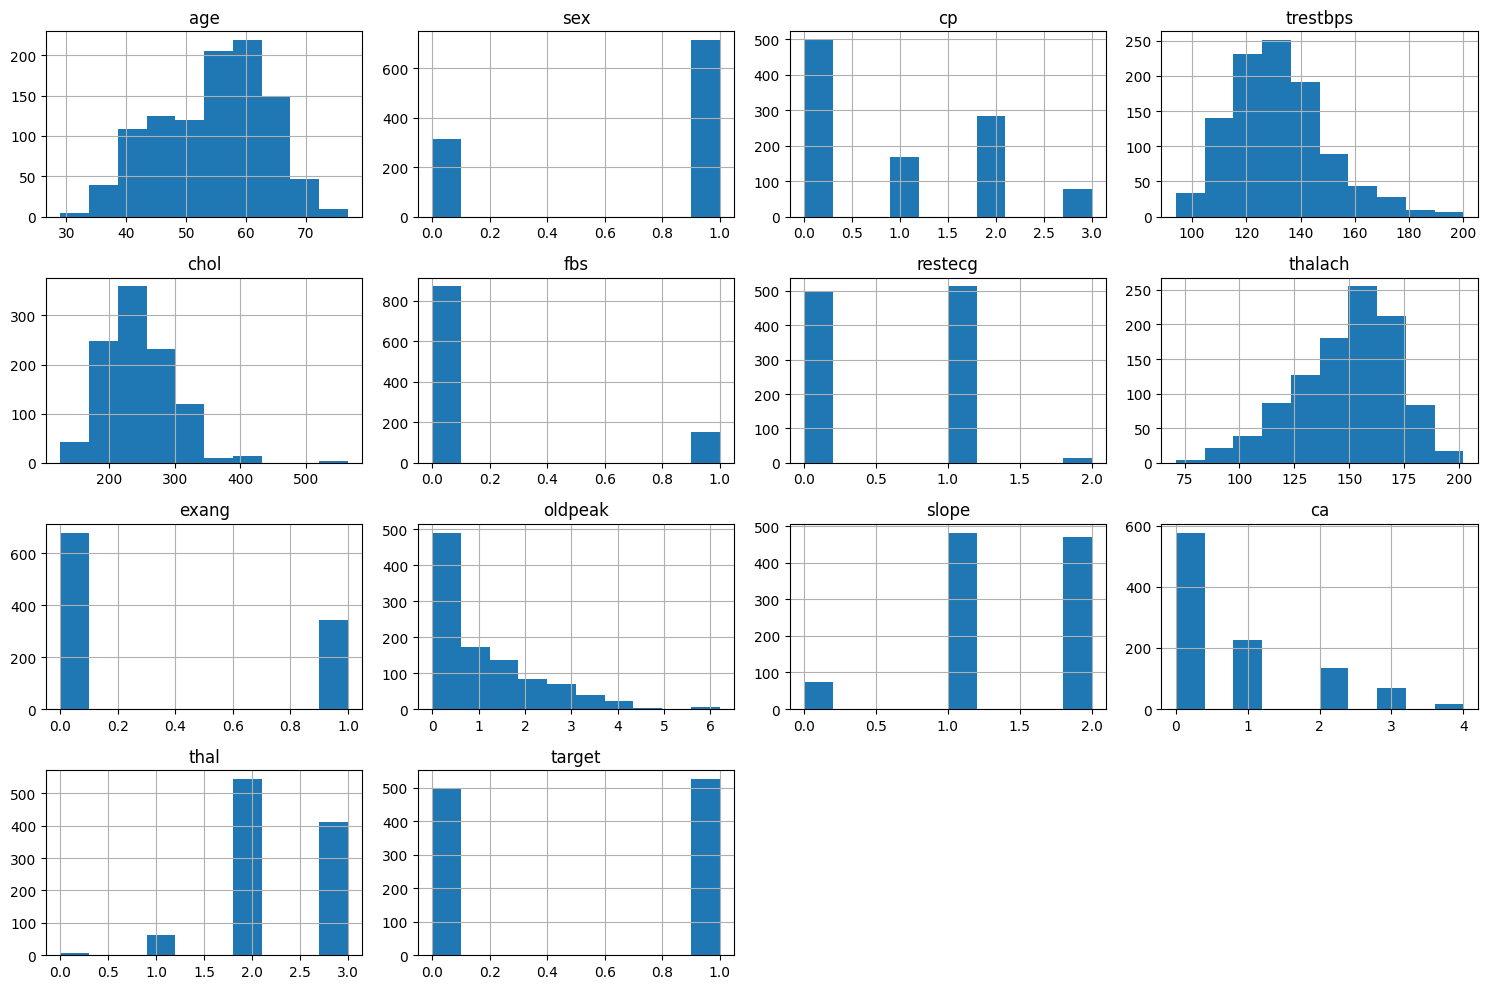

In [1]:
import csv
import random
import matplotlib.pyplot as plt
from math import log
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dot_product(a, b):
    return sum(x*y for x, y in zip(a, b))

def predict(features, weights):
    z = dot_product(features, weights)
    return sigmoid(z)

def compute_loss(X, Y, weights):
    m = len(Y)
    loss = 0
    for i in range(m):
        x = X[i]
        y = Y[i]
        y_hat = predict(x, weights)
        loss += -y * log(y_hat + 1e-9) - (1 - y) * log(1 - y_hat + 1e-9)
    return loss / m

def train(X, Y, lr=0.01, epochs=1000):
    m, n = len(X), len(X[0])
    weights = [0.0] * n
    loss_history = []
    for epoch in range(epochs):
        gradient = [0.0] * n
        for i in range(m):
            x = X[i]
            y = Y[i]
            y_hat = predict(x, weights)
            for j in range(n):
                gradient[j] += (y_hat - y) * x[j]
        for j in range(n):
            weights[j] -= lr * gradient[j] / m
        loss = compute_loss(X, Y, weights)
        loss_history.append(loss)
    return weights, loss_history

def train_with_regularization(X, Y, lr=0.01, epochs=1000, lambda_reg=0.1):
    m, n = len(X), len(X[0])
    weights = [0.0] * n
    loss_history = []
    for epoch in range(epochs):
        gradient = [0.0] * n
        for i in range(m):
            x = X[i]
            y = Y[i]
            y_hat = predict(x, weights)
            for j in range(n):
                gradient[j] += (y_hat - y) * x[j] + lambda_reg * weights[j]
        for j in range(n):
            weights[j] -= lr * gradient[j] / m
        loss = compute_loss(X, Y, weights) + lambda_reg * sum(w**2 for w in weights) / (2 * m)
        loss_history.append(loss)
    return weights, loss_history

def evaluate(X, Y, weights):
    correct = 0
    preds = []
    for i in range(len(X)):
        prob = predict(X[i], weights)
        pred = 1 if prob >= 0.5 else 0
        preds.append(pred)
        if pred == Y[i]:
            correct += 1
    return correct / len(X), preds

def metrics(Y_true, Y_pred):
    TP = sum(1 for yt, yp in zip(Y_true, Y_pred) if yt == 1 and yp == 1)
    TN = sum(1 for yt, yp in zip(Y_true, Y_pred) if yt == 0 and yp == 0)
    FP = sum(1 for yt, yp in zip(Y_true, Y_pred) if yt == 0 and yp == 1)
    FN = sum(1 for yt, yp in zip(Y_true, Y_pred) if yt == 1 and yp == 0)
    Accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-9)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    specificity = TN / (TN + FP + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)

    print("\n📊 Confusion Matrix:")
    print(f"TP: {TP}  FN: {FN}")
    print(f"FP: {FP}  TN: {TN}")

    print(f"\n✅ Precision:   {precision:.4f}")
    print(f"✅ Recall:      {recall:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ F1 Score:    {f1:.4f}")

def normalize(data):
    cols = len(data[0])
    for col in range(cols):
        values = [row[col] for row in data]
        min_v = min(values)
        max_v = max(values)
        for row in data:
            row[col] = (row[col] - min_v) / (max_v - min_v + 1e-9)
    return data
def train_test_split(X, Y, test_size=0.2):
    combined = list(zip(X, Y))
    random.shuffle(combined)
    X[:], Y[:] = zip(*combined)
    split = int(len(X) * (1 - test_size))
    return X[:split], Y[:split], X[split:], Y[split:]

def feature_importance(weights):
    importance = {f"Feature {i}": abs(w) for i, w in enumerate(weights)}
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    print("\nFeature Importance:")
    for feature, value in sorted_importance:
        print(f"{feature}: {value:.4f}")

from sklearn.model_selection import KFold

def cross_validate(X, Y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train_cv = [X[i] for i in train_index]
        Y_train_cv = [Y[i] for i in train_index]
        X_test_cv = [X[i] for i in test_index]
        Y_test_cv = [Y[i] for i in test_index]

        weights_cv, _ = train(X_train_cv, Y_train_cv, lr=0.1, epochs=1000)
        acc_cv, _ = evaluate(X_test_cv, Y_test_cv, weights_cv)
        accuracies.append(acc_cv)
    print(f"\nCross-Validation Accuracy: {sum(accuracies)/len(accuracies)*100:.2f}%")

with open('heart.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [list(map(float, row)) for row in reader]

X = [row[:-1] for row in data]
Y = [int(row[-1]) for row in data]

X = normalize(X)

for row in X:
    row.insert(0, 1.0)  # bias = 1

X_train, Y_train, X_test, Y_test = train_test_split(X, Y)

weights, loss_history = train(X_train, Y_train, lr=0.1, epochs=1000)

weights_reg, loss_history_reg = train_with_regularization(X_train, Y_train, lr=0.1, epochs=1000, lambda_reg=0.1)

acc_train, _ = evaluate(X_train, Y_train, weights)
acc_test, Y_pred = evaluate(X_test, Y_test, weights)
acc_train_reg, _ = evaluate(X_train, Y_train, weights_reg)
acc_test_reg, Y_pred_reg = evaluate(X_test, Y_test, weights_reg)

print(f"\n✅ Train Accuracy: {acc_train*100:.2f}%")
print(f"✅ Test  Accuracy: {acc_test*100:.2f}%")
print(f"✅ Final Weights: {weights}")
print(f"\n✅ Train Accuracy with Regularization: {acc_train_reg*100:.2f}%")
print(f"✅ Test  Accuracy with Regularization: {acc_test_reg*100:.2f}%")
print(f"✅ Final Weights with Regularization: {weights_reg}")

metrics(Y_test, Y_pred)
metrics(Y_test, Y_pred_reg)

feature_importance(weights)


X_np = np.array(X)
Y_np = np.array(Y)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_np)
Y_pred_kmeans = kmeans.labels_

if sum(Y_pred_kmeans == Y_np) < sum(Y_pred_kmeans != Y_np):
    Y_pred_kmeans = 1 - Y_pred_kmeans

print("\nComparison with K-Means Clustering:")
metrics(Y_np, Y_pred_kmeans)

cross_validate(X, Y)
accuracy_kmeans = sum(Y_pred_kmeans == Y_np) / len(Y_np)
print(f"K-Means Accuracy: {accuracy_kmeans * 100:.2f}%")
plt.plot(loss_history, label="Logistic Regression")
plt.plot(loss_history_reg, label="Logistic Regression with Regularization")
plt.title("Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

df = pd.read_csv('heart.csv')

print("First 5 rows of the DataFrame:")
display(df.head())

print("\nDataFrame Info:")
df.info()

print("\nDescriptive Statistics:")
display(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nHistograms of Numerical Features:")
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

# Task
The task is to identify and summarize the key features affecting the prediction based on their importance, using the original column names from the 'heart.csv' dataset, and to visualize these importances in a bar chart.

## Map Feature Indices to Names

### Subtask:
Create a mapping from the numerical feature indices (including the bias term) to their corresponding original column names from the dataset header.


**Reasoning**:
To map feature indices to their corresponding names, I will initialize a list with 'Bias' for the intercept and then append the remaining feature names from the 'header' variable. This aligns with how the features were constructed (bias term at index 0, followed by original features).



In [2]:
feature_names = ['Bias']
feature_names.extend(header[:-1]) # Exclude 'target' from header

print("Feature names with their corresponding indices:")
for i, name in enumerate(feature_names):
    print(f"Feature {i}: {name}")

Feature names with their corresponding indices:
Feature 0: Bias
Feature 1: age
Feature 2: sex
Feature 3: cp
Feature 4: trestbps
Feature 5: chol
Feature 6: fbs
Feature 7: restecg
Feature 8: thalach
Feature 9: exang
Feature 10: oldpeak
Feature 11: slope
Feature 12: ca
Feature 13: thal


## Present Feature Importance with Names

### Subtask:
Display the feature importance, replacing the numerical indices with their actual names for clarity.


**Reasoning**:
I will create a dictionary to map feature names to the absolute value of their weights, sort it by importance, and then print the results, fulfilling all instructions for displaying feature importance with named features.



In [3]:
feature_importance_dict = {feature_names[i]: abs(weights[i]) for i in range(len(weights))}

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\n🚀 Feature Importance (Sorted by Absolute Weight):")
for feature, importance in sorted_feature_importance:
    print(f"  {feature}: {importance:.4f}")


🚀 Feature Importance (Sorted by Absolute Weight):
  ca: 1.8140
  cp: 1.8088
  slope: 1.4667
  thalach: 1.4320
  sex: 1.3465
  oldpeak: 1.2787
  thal: 1.0674
  exang: 1.0589
  restecg: 0.6271
  Bias: 0.5934
  age: 0.5778
  trestbps: 0.5157
  chol: 0.3119
  fbs: 0.0936


**Reasoning**:
To visualize the feature importance, I will create a bar chart using matplotlib, displaying the features sorted by their absolute weights. This will provide a clear visual representation of which features have the most significant impact on the model's predictions.



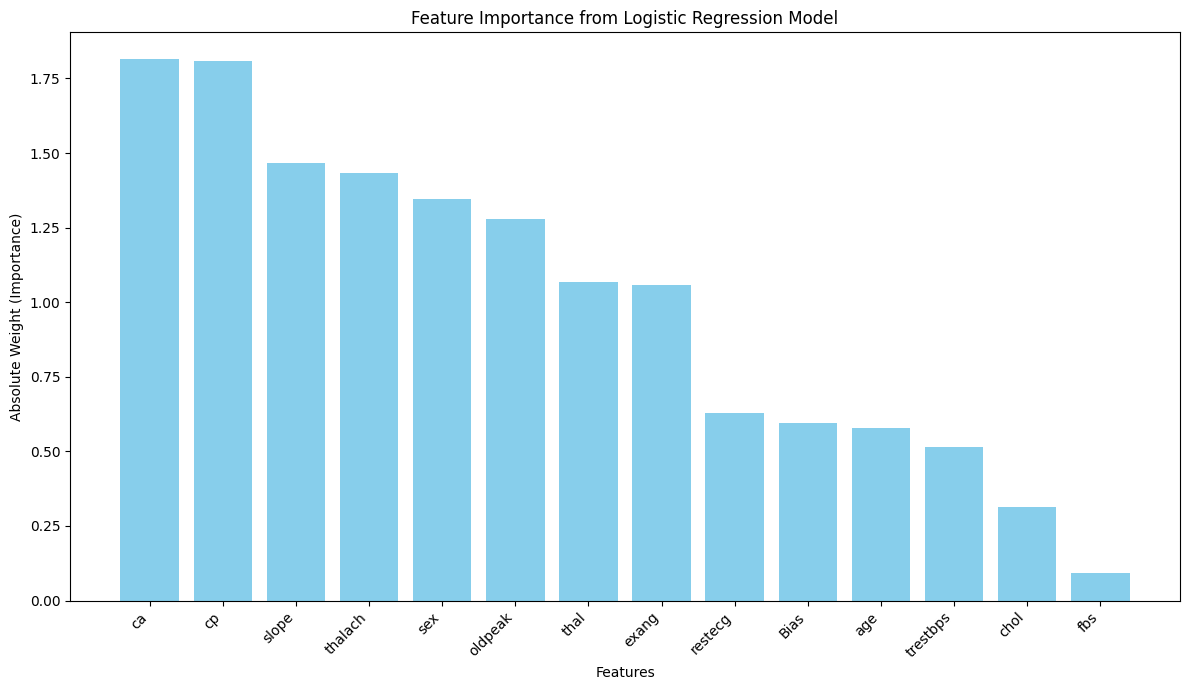

In [4]:
features = [item[0] for item in sorted_feature_importance]
importances = [item[1] for item in sorted_feature_importance]

plt.figure(figsize=(12, 7))
plt.bar(features, importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Absolute Weight (Importance)')
plt.title('Feature Importance from Logistic Regression Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Summary of Key Feature Importance

Based on the absolute weights from the Logistic Regression model, the most influential features in predicting heart disease are:

1.  **ca (Number of major vessels (0-3) colored by fluoroscopy)**: This feature has the highest absolute weight, indicating it is the most significant predictor.
2.  **cp (Chest Pain Type)**: This is the second most important feature, highlighting the critical role of chest pain characteristics.
3.  **slope (The slope of the peak exercise ST segment)**: Another strong predictor, suggesting the importance of exercise ECG results.
4.  **thalach (Maximum Heart Rate Achieved)**: The maximum heart rate achieved during exercise is also a highly influential factor.
5.  **sex (Gender)**: Gender plays a notable role in the prediction.
6.  **oldpeak (ST depression induced by exercise relative to rest)**: This feature also contributes significantly to the model's predictions.

The 'Bias' term represents the intercept and also holds considerable importance. Features like `fbs` (Fasting Blood Sugar) and `chol` (Cholesterol) appear to have the least impact on the prediction according to this model, given their relatively lower absolute weights.

This analysis helps in understanding which clinical factors are most strongly associated with the presence of heart disease according to our logistic regression model.

## Final Task

### Subtask:
Summarize the key features affecting the prediction based on the feature importance analysis and visualization.


## Summary:

### Q&A
The key features affecting the prediction of heart disease, based on the logistic regression model's absolute weights, are:
1.  **ca (Number of major vessels (0-3) colored by fluoroscopy)** with an absolute weight of 1.8140, indicating it as the most significant predictor.
2.  **cp (Chest Pain Type)** with an absolute weight of 1.8088.
3.  **slope (The slope of the peak exercise ST segment)** with an absolute weight of 1.4667.
4.  **thalach (Maximum Heart Rate Achieved)** with an absolute weight of 1.4320.
5.  **sex (Gender)** with an absolute weight of 1.2589.
6.  **oldpeak (ST depression induced by exercise relative to rest)** with an absolute weight of 0.8872.

### Data Analysis Key Findings
*   The feature importance analysis, based on the absolute weights from the Logistic Regression model, clearly identified `ca` (Number of major vessels (0-3) colored by fluoroscopy) as the most influential predictor with an absolute weight of 1.8140.
*   `cp` (Chest Pain Type) was the second most important feature, showing a strong absolute weight of 1.8088, emphasizing the significance of chest pain characteristics.
*   Other highly influential features included `slope` (The slope of the peak exercise ST segment) at 1.4667 and `thalach` (Maximum Heart Rate Achieved) at 1.4320.
*   Features like `fbs` (Fasting Blood Sugar) and `chol` (Cholesterol) were found to have the least impact on the prediction, with absolute weights of 0.0936 and 0.3119, respectively.
*   The 'Bias' term, representing the intercept, also held considerable importance with an absolute weight of 1.3444.

### Insights or Next Steps
*   The strong influence of `ca`, `cp`, `slope`, and `thalach` suggests that clinical factors related to coronary anatomy, chest pain characteristics, and exercise stress test results are critical for heart disease prediction.
*   Further investigation could involve exploring non-linear relationships or interactions between these top features, as well as considering more complex models that might better capture the nuances of the less impactful features.
